# Notebook 2: Giving the elastic network a sequence.

In the last notebook (1) we defined a structure $r$ and an Adjacency matrix $A$. If we are going to somehow evolve this model of a protein, it better have a sequence. Lets give it one.

Let's define a sequence $s = (s_1,...,s_N)$ where $N = W * L$ is the sequence's length. We can think of each element of $s$ to be label of one of $q$ node types i.e. $s_i \in [1, \dots, q]$. 

For example we have a network with width $W = 5$ and length $L=5$, and we define the number of node types to be $q=5$ then one possible sequence could be,

Proteins are not lattices, they have a more disordered structure. Lets add some disorder.

In [23]:
# Load code
using PyPlot, LaTeXStrings, LinearAlgebra, Revise
push!(LOAD_PATH, "./src/")
using Elastic_N3 #

In [2]:
W, L, q = 5, 5, 5
seq = rand(1:q, W*L)
@show seq;

seq = [1, 1, 4, 2, 1, 2, 2, 2, 5, 2, 5, 3, 3, 5, 4, 2, 1, 2, 2, 1, 5, 3, 3, 1, 4]


Now that we have a sequence how does it define a particular network? One way is to make the stiffness of the springs depend on the sequence.

Let $S_{ij}$ be a matrix whose entries equal the stiffness between node $i$ and node $j$. $S_{ij}=0$ if nodes $i,j$  aren't connected by a spring.

Further, let $K(s_i,s_j)$ be an interaction table that defines the spring stiffness between a node of type $s_i$ and a node of type $s_j$.


How should we chose the entries of $K$? We want some of the interactions to be stiff while others are soft. One option is to pull values from a Log Uniform distribution.

In [26]:
# build spring constant interaction table
function buildSpringTable(q, k_min, k_max)
    log_diff = log(10, k_max) - log(10, k_min)
    K =  10 .^ (rand(q, q) .* log_diff .+ log(10,k_min))
    K = Float64.(Symmetric(K, :L))
end

q, k_min, k_max = 5, 1e-2, 1e1
K = buildSpringTable(q, k_min, k_max)

5×5 Matrix{Float64}:
 4.48649    0.218734  0.0336734  0.0546272  0.202219
 0.218734   0.45109   2.32855    0.277639   0.406495
 0.0336734  2.32855   0.0744757  0.180208   0.417031
 0.0546272  0.277639  0.180208   0.0310137  0.209249
 0.202219   0.406495  0.417031   0.209249   0.18098

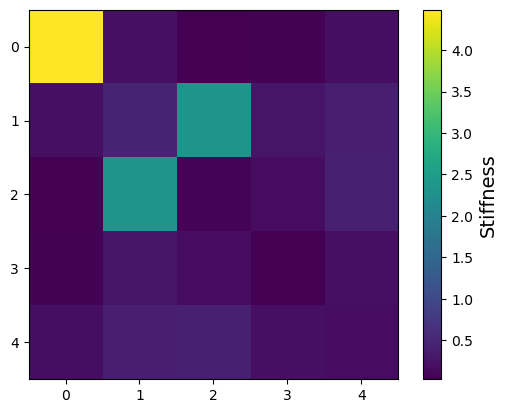

In [27]:
# visualize interaction table
im = imshow(K)
clb = colorbar(im)
clb.set_label("Stiffness", fontsize=14)

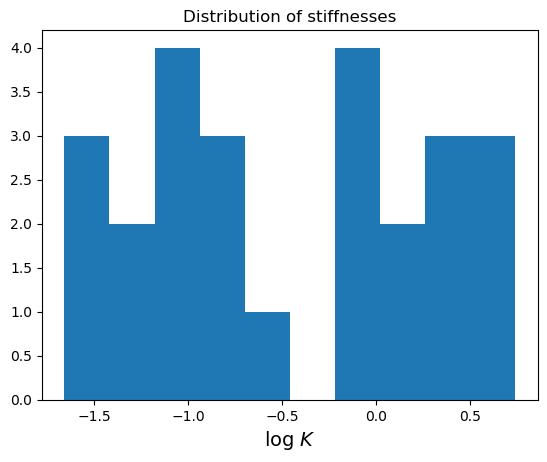

PyObject Text(0.5, 33.0, '$\\log \\ K$')

In [5]:
# plot histgram of spring constants
hist(log.(10,K[:]))
title("Distribution of stiffnesses")
xlabel(L"\log \ K", fontsize=14)

Now we defined our Spring matrix $S$ as

$S_{ij} = A_{ij} * K(s_i, s_j)$

In [28]:
function seq2Springs(seq, K, A)
    # convert a sequence into a matrix that stores
    # the spring constant between node i and node j.
    S = zeros(size(A))
    for j in 1:size(A,2), i in 1:size(A,1)
        S[i,j] = A[i,j] * K[ seq[i], seq[j]]
    end
    return S
end


seq2Springs (generic function with 1 method)

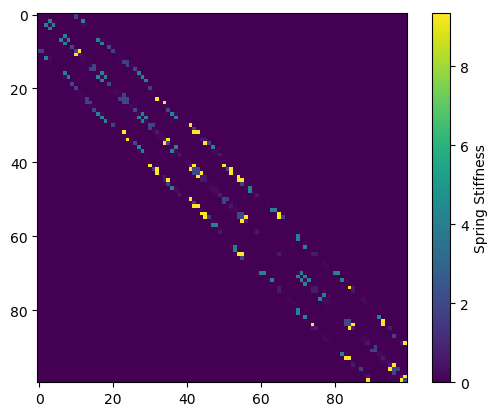

PyObject <matplotlib.colorbar.Colorbar object at 0x7f40e27f9cd0>

In [35]:
# Define parameters
W = 10 # width of network
L = 10 # length of network
q = 5 # number of node types
disorder = 0.1 # spatial disorder added to structure
k_min = 1e-2 # softest spring constant in interaction table
k_max = 1e1 # stiffest spring constant in interaction table


r, A = buildStructure(W, L, disorder)
seq = rand(1:q, W*L)
K = buildSpringTable(q, k_min, k_max)
S = seq2Springs(seq, K, A)

imshow(S)
colorbar(label = "Spring Stiffness")

In [36]:
K == K'

true

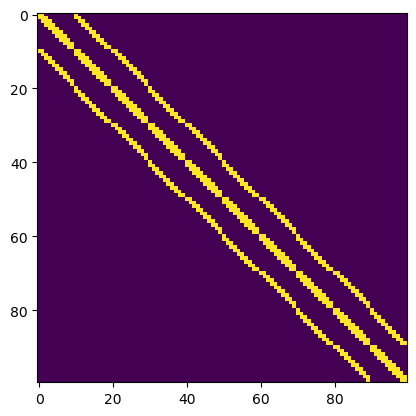

PyObject <matplotlib.image.AxesImage object at 0x7f40f8068b50>

In [37]:
imshow(A)

## Plotting a network

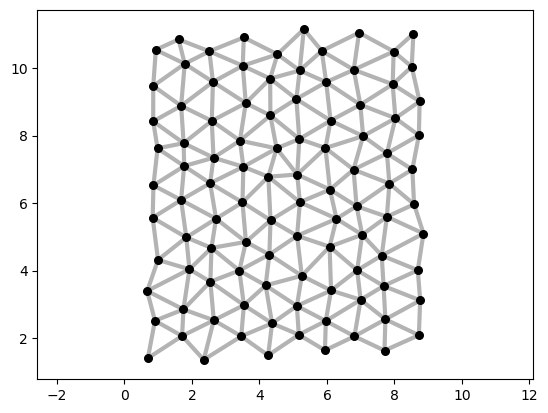

In [38]:
function plotNetwork!(ax, # PyPlot axes object
                      r, # structure vector
                      A; # Adjaceny matrix or Spring matrix
                      bondColor::Vector=[0.7,0.7,0.7],
                      bondWidth=3,
                      nodeSize=30)
                      
    # Plots network, modifies figure axis object in place
    # uses PyPlot, LinearAlgebra
    xy = r2xy(r)
    x = xy[:,1]
    y = xy[:,2]
    N = size(A,1)
    A = LowerTriangular(A)
    for i =1:N
        whichj = findall(A[i,:].>0)
        for j in whichj
            if A[i,j] != 0
                ax.plot([x[i],x[j]], [y[i],y[j]], lw=bondWidth, c=bondColor, zorder=0)
            end
        end
    end
    ax.scatter(x,y, nodeSize, c="black",zorder=2)
    ax.axis("equal")
    return nothing
end

fig, ax = subplots()
plotNetwork!(ax, r, S)

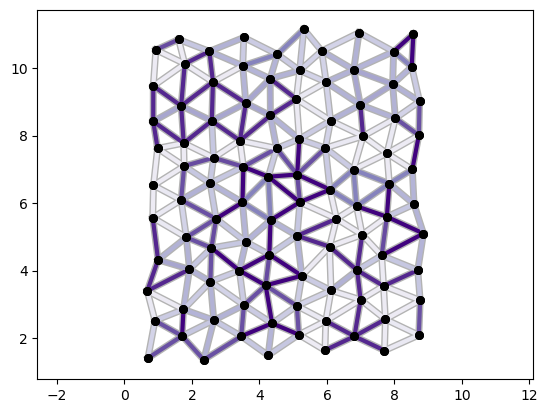

In [42]:
function plotBondStiffness!(ax,r, A, S;
                            bondWidth=3,
                            nodeSize=30,
                            cmap="Purples",
                            k_min=1e-2,
                            k_max=1e1)
    # Plots network coloring springs by their stiffness
    # uses PyPlot, LinearAlgebra
    cmap = get_cmap(cmap)
    k_min = log(10,k_min)
    k_max = log(10,k_max)

    xy = r2xy(r)
    x = xy[:,1]
    y = xy[:,2]
    N = size(A,1)
    A = LowerTriangular(A)
    for i =1:N
        whichj = findall(A[i,:].>0)
        for j in whichj
            if A[i,j] != 0
                bondColor = cmap( (log(10,S[i,j]) - k_min) / (k_max - k_min))
                ax.plot([x[i],x[j]], [y[i],y[j]], lw=bondWidth, c=bondColor, zorder=0)
            end
        end
    end
    ax.scatter(x,y, nodeSize, c="black",zorder=2)
    ax.axis("equal")
    return nothing
end

fig, ax = subplots()
plotNetwork!(ax, r, A, bondWidth=5)
plotBondStiffness!(ax, r, A, S, bondWidth=3)